In [1]:
!pip install networkx

In [2]:
# Import Libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

/home/yyko/micromamba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Read Data
candidate_sentences = pd.read_csv("/home/yyko/workspace/political_pre/KG_construction/KGap.csv")
print(candidate_sentences.shape)
candidate_sentences['sentence'].sample(5)

(10703, 1)


8894    BruceRauner affiliated_to republican
9473        JasonSmith oppose liberal_values
712           RonWyden is_a_member_of senate
2886                    MikeTurner from ohio
5827    SusanBrooks affiliated_to republican
Name: sentence, dtype: object

In [28]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [5]:
# Entity Pairs Extraction
def get_entities(sent):
      ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 10703/10703 [00:27<00:00, 394.53it/s]


In [9]:
entity_pairs[10:20]

[['', 'alaska'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', 'alaska'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', 'arizona'],
 ['', '']]

In [10]:
# Relation / Predicate Extraction
def get_relation(sent):
    
  doc = nlp(sent)
  # Matcher class object 
  matcher = Matcher(nlp.vocab)
  relation=[]
  
  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None)

  matches = matcher(doc)
  
  for mathc_id, start, end in matches:
        matched_span = doc[start: end]
        # print(matched_span.text)
        relation.append(matched_span.text)
  return relation
  
  # k = len(matches) - 1
  # span = doc[matches[k][1]:matches[k][2]] 

  # return(span.text)

In [11]:
get_relation("John completed the task")

['completed']

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 10703/10703 [00:29<00:00, 365.02it/s]


In [13]:
pd.Series(relations).value_counts()[:50]

[house]                                        1730
[republican]                                   1027
[democrat]                                      983
[conservative_values]                           601
[liberal_values]                                523
[senate]                                        409
[overlap_with]                                  286
[oppose]                                        226
[117thcongress, 117thcongress overlap_with]     220
[115thcongress]                                 134
[114thcongress]                                 118
[117thcongress]                                  97
[governor]                                       89
[favor]                                          59
[116thcongress]                                  44
[116thcongress, 116thcongress overlap_with]      37
[115thcongress, 115thcongress overlap_with]      31
[114thcongress, 114thcongress overlap_with]      19
[SCOTUS]                                         11
[RobinKelly]

In [59]:
# KGAP
kgap_triples = pd.read_csv("/home/yyko/workspace/political_pre/KG_construction/KGap.csv")
print(kgap_triples.shape)
kgap_triples['sentence'].sample(5)

(10703, 1)


8127    KathyManning affiliated_to democrat
7507     MikeQuigley affiliated_to democrat
7030             RickCrawford from arkansas
2898                      TimRyan from ohio
3490            DougLaMalfa from california
Name: sentence, dtype: object

In [60]:
a = kgap_triples['sentence'][2].split()
a

['JeffSessions', 'from', 'alabama']

In [61]:
triplet = []

for i in tqdm(kgap_triples["sentence"]):
      triplet.append(i.split())
      # print(i)

100%|██████████| 10703/10703 [00:00<00:00, 1740728.05it/s]


In [62]:
print(triplet[0])
print(triplet[0][0])
print(triplet[0][1])

['JeffSessions', 'is_a_member_of', 'senate']
JeffSessions
is_a_member_of


In [ ]:
e = [i[0] for i in triplet]
e

In [52]:
relations = [i[1] for i in triplet]
relations

['is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliated_to',
 'is_a_member_of',
 'overlap_with',
 'from',
 'affiliat

In [53]:
relations[0]

'is_a_member_of'

In [63]:
# extract subject
source = [i[0] for i in triplet]

# extract predicate
relations = [i[1] for i in triplet]

# extract object
target = [i[2] for i in triplet]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

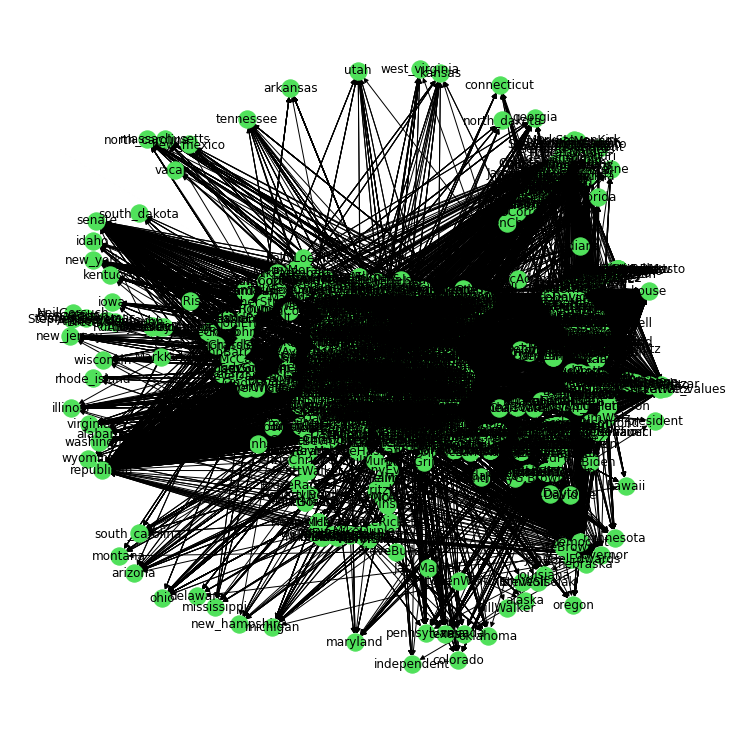

In [67]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='#50E15B', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [56]:
kg_df

,source,target,edge
0,JeffSessions,senate,is_a_member_of
1,114thcongress,JeffSessions,overlap_with
2,JeffSessions,alabama,from
3,JeffSessions,republican,affiliated_to
4,RichardShelby,senate,is_a_member_of
...,...,...,...
10698,TimWalz,conservative_values,oppose
10699,RobWoodall,conservative_values,neutral
10700,KevinYoder,conservative_values,neutral
10701,TedYoho,conservative_values,favor


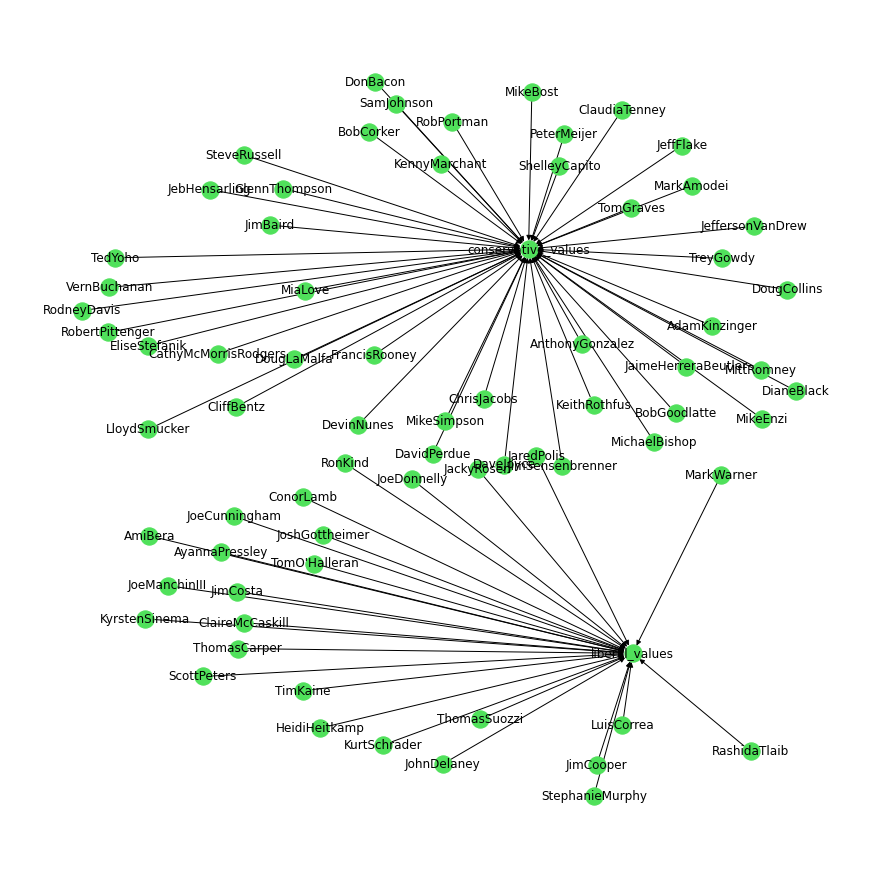

In [91]:
# # extract subject
# source = [i[0] for i in entity_pairs]

# # extract object
# target = [i[1] for i in entity_pairs]

# kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

G=nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "favor"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.3)
nx.draw(G, with_labels=True, node_color='#50E15B', node_size=300, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

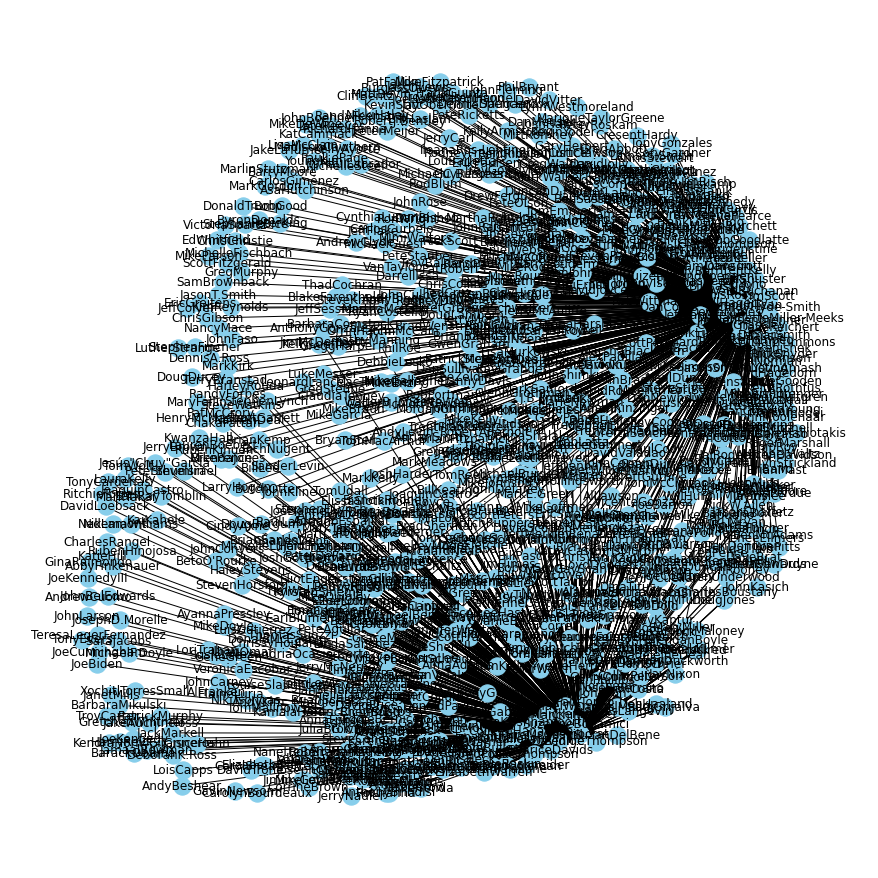

In [93]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "affiliated_to"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.3)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=300, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()